In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')

from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, Phrases

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

import json


stop_words = set(stopwords.words('english'))
ps = PorterStemmer()


In [129]:
# text2tokens, gen_bow, porterstemmer
def text2tokens(text):
	stop_words = set(stopwords.words('english'))
	text = str(text)
	text = text.lower()
	textList = word_tokenize(text)
	textList = [word for word in textList if word not in stop_words and len(word) >= 3]

	textList = [ps.stem(word) for word in textList]
	return textList
    
def gen_bow(df, column):
	df['tokens'] = df[column].apply(text2tokens)
	dct = Dictionary(df['tokens'])
	dct.filter_extremes(no_below=5, no_above=0.5)
	df['bow'] = df['tokens'].apply(dct.doc2bow)
	worddict = {}
	for i in range(len(df)):
		for token in df.at[i,'bow']:
			if token in list(worddict.keys()):
				worddict[token] += 1
			else: 
				worddict[token] = 1

	df.drop('tokens', axis=1, inplace=True)	
	return df, worddict

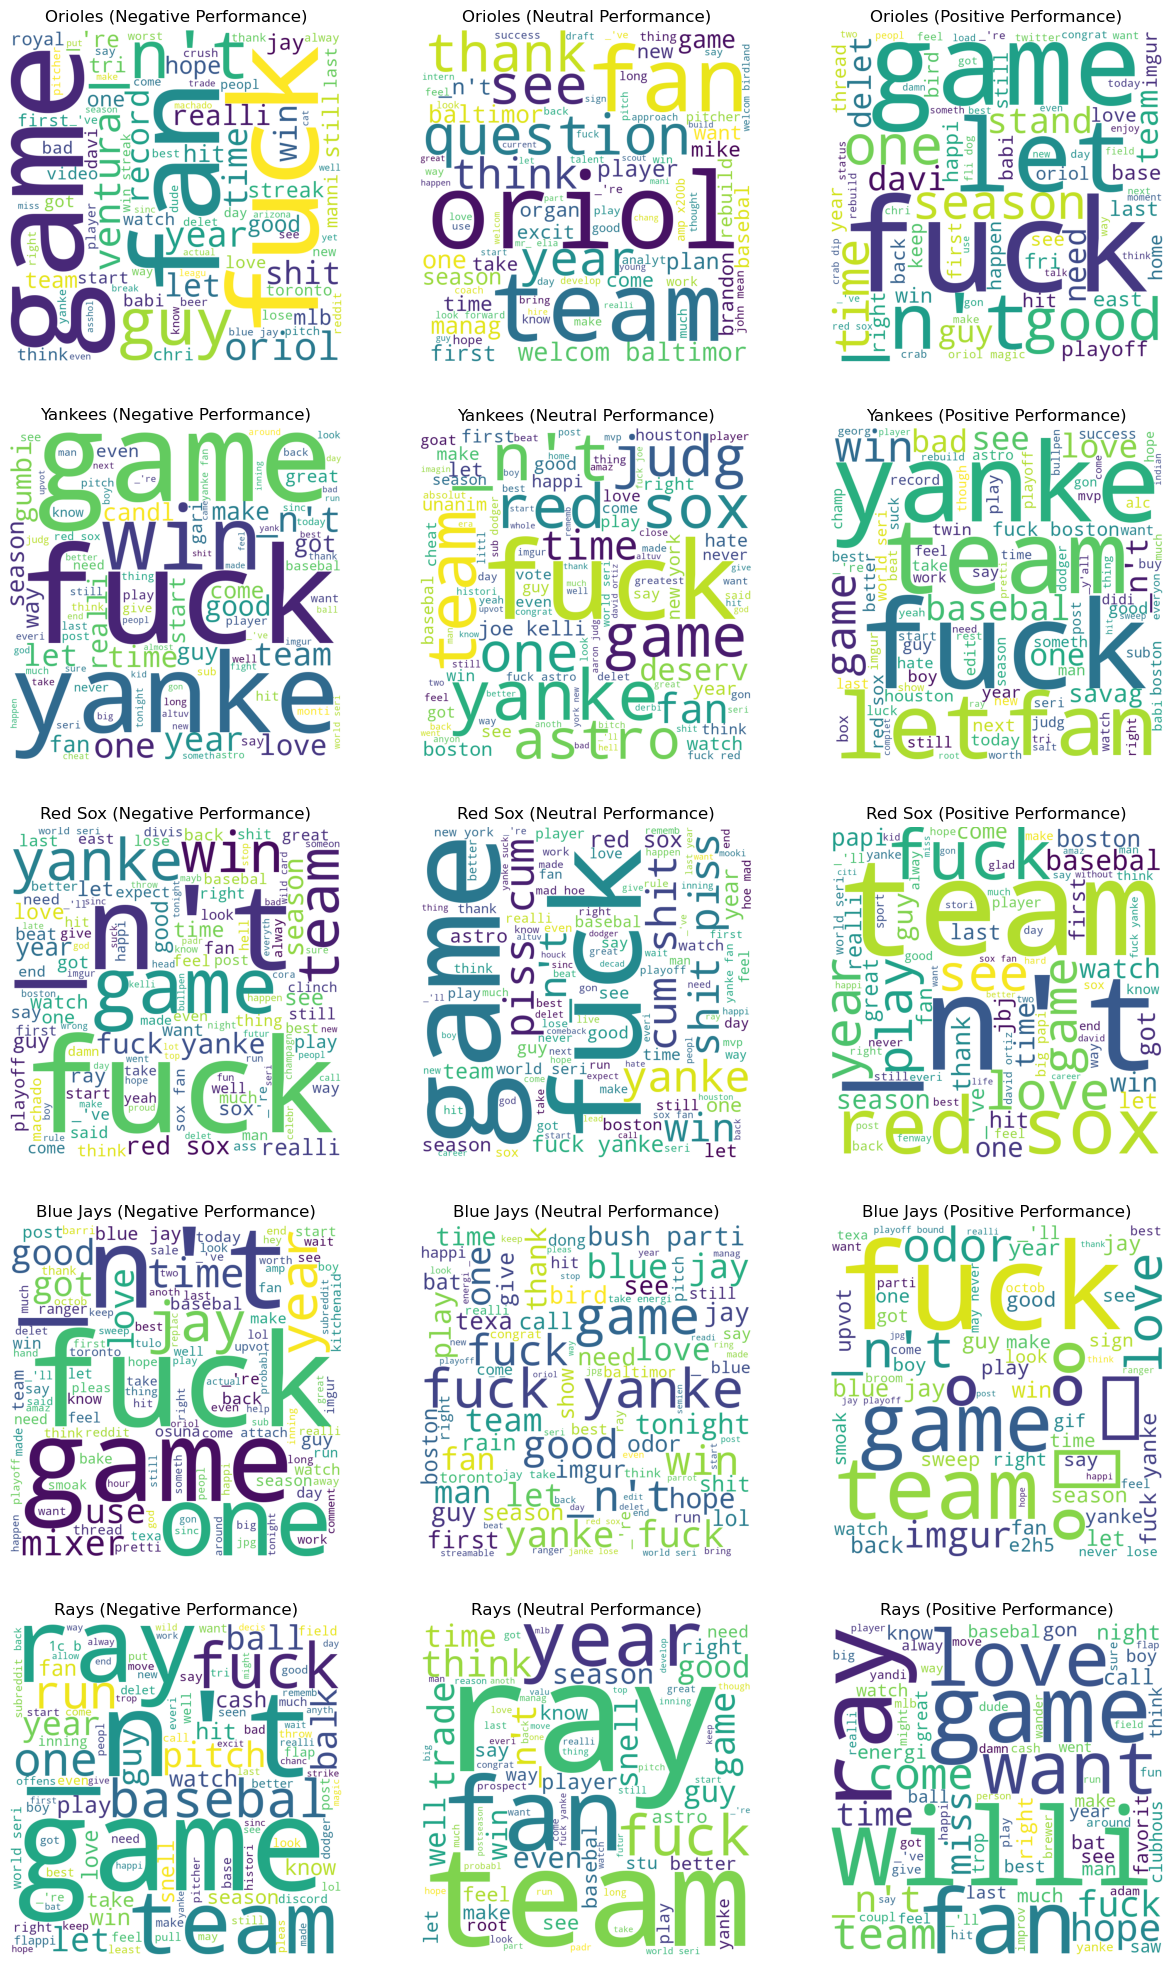

In [130]:
rdf = pd.read_csv('hw2_step2_reddit_posts.csv')
rdf['tokens'] = rdf['tokens'].apply(lambda tw: word_tokenize(tw))

phraser = Phrases(rdf['tokens'], min_count=5, delimiter= '_')
# display(rdf)
rdf['tokens'] = rdf['tokens'].apply(lambda tw: phraser[tw])

stop_words = set(stopwords.words('english'))
rdf['tokens'] = rdf['tokens'].apply(lambda  tks: [tk for tk in tks if tk not in stop_words])
rdf['tokens'] = rdf['tokens'].apply(lambda tks: [tk for tk in tks if len(tk) > 3])


bal_posts = rdf.loc[rdf['team'] == 'BAL']
nyy_posts = rdf.loc[rdf['team'] == 'NYY']
bos_posts = rdf.loc[rdf['team'] == 'BOS']
tor_posts = rdf.loc[rdf['team'] == 'TOR']
tb_posts = rdf.loc[rdf['team'] == 'TB']








# Subdivide each team into graphs based on team_performance column values

# Function to generate word cloud for a specific subset of posts
def generate_wordcloud(posts, title):
	words = []
	for doc in posts['tokens']:
		words.extend(doc)
	wordcloud_text = ' '.join(words)
	wordcloud = WordCloud(width=800, height=800,
						  background_color='white',
						  min_font_size=20).generate(wordcloud_text)
	plt.imshow(wordcloud)
	plt.axis('off')
	plt.title(title)
	

plt.figure(figsize=(15,25))

# word clouds for BAL 

plt.subplot(5,3,1)
generate_wordcloud(bal_posts[bal_posts['team_performance'] < 0], 'Orioles (Negative Performance)')
plt.subplot(5,3,2)
generate_wordcloud(bal_posts[bal_posts['team_performance'] == 0], 'Orioles (Neutral Performance)')
plt.subplot(5,3,3)
generate_wordcloud(bal_posts[bal_posts['team_performance'] > 0], 'Orioles (Positive Performance)')

# word clouds for NYY

plt.subplot(5,3,4)
generate_wordcloud(nyy_posts[nyy_posts['team_performance'] < 0], 'Yankees (Negative Performance)')
plt.subplot(5,3,5)
generate_wordcloud(nyy_posts[nyy_posts['team_performance'] == 0], 'Yankees (Neutral Performance)')
plt.subplot(5,3,6)
generate_wordcloud(nyy_posts[nyy_posts['team_performance'] > 0], 'Yankees (Positive Performance)')

# word clouds for BOS

plt.subplot(5,3,7)
generate_wordcloud(bos_posts[bos_posts['team_performance'] < 0], 'Red Sox (Negative Performance)')
plt.subplot(5,3,8)
generate_wordcloud(bos_posts[bos_posts['team_performance'] == 0], 'Red Sox (Neutral Performance)')
plt.subplot(5,3,9)
generate_wordcloud(bos_posts[bos_posts['team_performance'] > 0], 'Red Sox (Positive Performance)')

# word clouds for TOR

plt.subplot(5,3,10)
generate_wordcloud(tor_posts[tor_posts['team_performance'] < 0], 'Blue Jays (Negative Performance)')
plt.subplot(5,3,11)
generate_wordcloud(tor_posts[tor_posts['team_performance'] == 0], 'Blue Jays (Neutral Performance)')
plt.subplot(5,3,12)
generate_wordcloud(tor_posts[tor_posts['team_performance'] > 0], 'Blue Jays (Positive Performance)')

# word clouds for TB

plt.subplot(5,3,13)
generate_wordcloud(tb_posts[tb_posts['team_performance'] < 0], 'Rays (Negative Performance)')
plt.subplot(5,3,14)
generate_wordcloud(tb_posts[tb_posts['team_performance'] == 0], 'Rays (Neutral Performance)')
plt.subplot(5,3,15)
generate_wordcloud(tb_posts[tb_posts['team_performance'] > 0], 'Rays (Positive Performance)')



In [160]:
gdf = pd.read_csv('hw2_step2_games.csv')
gdf.sort_values(by='date')

bal_games = gdf.loc[(gdf['home'] == 'BAL') | (gdf['away'] == 'BAL')]
nyy_games = gdf.loc[(gdf['home'] == 'NYY') | (gdf['away'] == 'NYY')]
bos_games = gdf.loc[(gdf['home'] == 'BOS') | (gdf['away'] == 'BOS')]
tor_games = gdf.loc[(gdf['home'] == 'TOR') | (gdf['away'] == 'TOR')]
tb_games = gdf.loc[(gdf['home'] == 'TB') | (gdf['away'] == 'TB')]

team_sdfs = {
    "BAL": bal_games,
    "NYY": nyy_games,
    "BOS": bos_games,
    "TOR": tor_games,
    "TB": tb_games
}

team_ids = ['BOS','TOR','TB','NYY','BAL']


for id in team_ids:
    team_games = team_sdfs[id]
    queue = []
    for idx, row in team_games.iterrows():
        if row['winner'] == id:
            queue.append(1)
        else:
            queue.append(0)

        if len(queue) > 10:
            queue.pop(0)
        team_games.at[idx, 'strength'] = sum(queue) / 10
    team_sdfs[id] = team_games
        

bal_posts = rdf.loc[rdf['team'] == "BAL"]
nyy_posts = rdf.loc[rdf['team'] == "NYY"]
bos_posts = rdf.loc[rdf['team'] == "BOS"]
tor_posts = rdf.loc[rdf['team'] == "TOR"]
tb_posts = rdf.loc[rdf['team'] == "TB"]  

team_posts = {
    "BAL": bal_posts,
    "NYY": nyy_posts,
    "BOS": bos_posts,
    "TOR": tor_posts,
    "TB": tb_posts
}

display(bal_posts)

C:\Users\ellio\AppData\Local\Temp\ipykernel_28708\1525775103.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_games.at[idx, 'strength'] = sum(queue) / 10
C:\Users\ellio\AppData\Local\Temp\ipykernel_28708\1525775103.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_games.at[idx, 'strength'] = sum(queue) / 10
C:\Users\ellio\AppData\Local\Temp\ipykernel_28708\1525775103.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,Unnamed: 0,text,time_of_post,game,team,tokens,sentiment,team_performance
1190,452,I'm a Jays fan. The have some horrible fans. C...,2016-10-05,['361004114'],BAL,"['jay, 'fan, 'horribl, 'fan, 'crazi, 'hockey, ...",0.260223,-1.0
1191,453,On behalf of my family and friends who are Jay...,2016-10-05,['361004114'],BAL,"['behalf, 'famili, 'friend, 'jay, 'fan, 'apolo...",0.308550,-1.0
1193,455,The Blue Jays should have had to forfeit the g...,2016-10-05,['361004114'],BAL,"['blue, 'jay, 'forfeit, 'game, 'shit, 'extrem,...",0.260223,-1.0
1194,456,"The guy was just acting like Joey Bats, why is...",2016-10-05,['361004114'],BAL,"['guy, 'act, 'like, 'joey, 'bat, 'anyon, 'surp...",0.263941,-1.0
1195,457,[removed],2016-10-05,['361004114'],BAL,['remov],0.256506,-1.0
...,...,...,...,...,...,...,...,...
6305,721,SCHOOP MAY BE THE NEXT ROBERTO ALOMAR.,2016-07-31,['360731114'],BAL,"['schoop, 'may, 'next, 'roberto, 'alomar]",0.260223,1.0
6306,720,WE LOST IT\n\nHAVE IT\n\nKEEP IT \n\nWIN IT,2016-07-31,['360731114'],BAL,"['lost, 'keep, 'win]",0.256506,1.0
6307,719,Ain't the beer cold!,2016-07-31,['360731114'],BAL,"[``_n't, 'beer, 'cold]",0.252788,1.0
6308,718,"Well, being at the top was fun while it lasted...",2016-07-31,['360731114'],BAL,"['well, 'top, 'fun, 'last, 'good, 'game]",0.275093,1.0


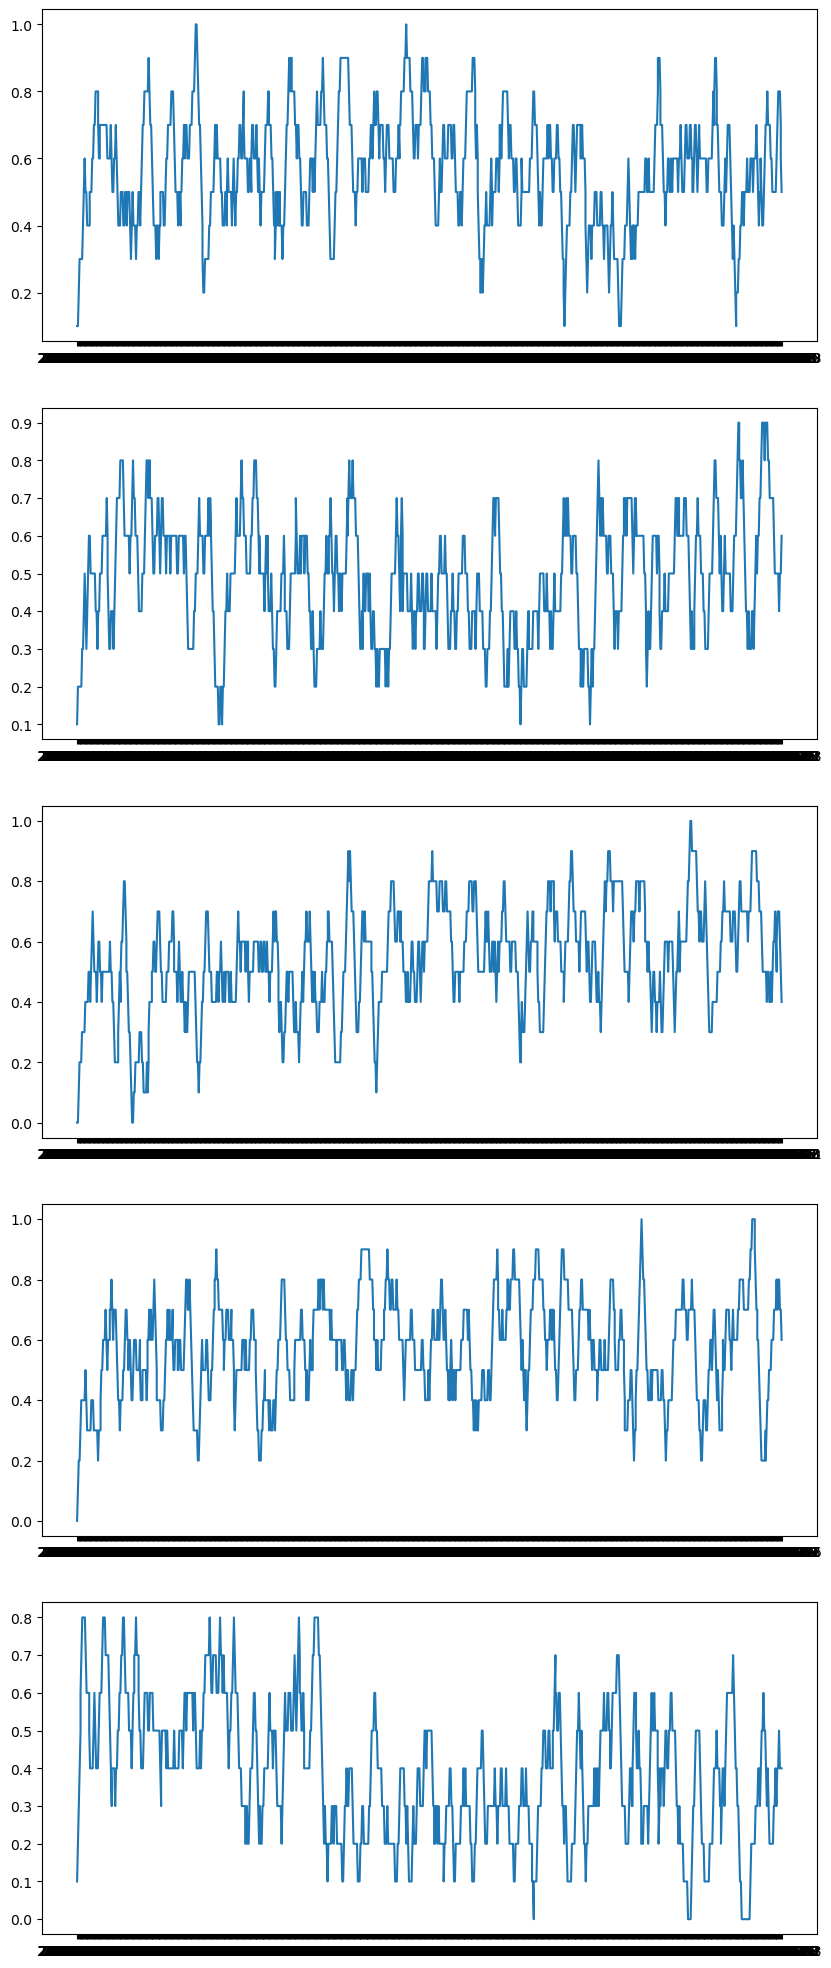

In [ ]:
from datetime import datetime
from scipy.stats import norm


graph = 1
plt.figure(figsize= (10, 25))
for id in team_ids:
    team_games = team_sdfs[id]
    
    plt.subplot(5,1,graph)
    graph += 1
    plt.plot(team_games['date'], team_games['strength'])
    plt.title(id + " performance over time")

    # posts = team_posts[id]
    # sent_over_time = posts.groupby(by='time_of_post')['sentiment'].apply(list)
    # # posts = posts.sort_values(by='time_of_post')
    # display(sent_over_time)
    # plt.plot(posts['time_of_post'], sent_over_time)
    